In [2]:
!python3 -m pip install --upgrade --quiet google-genai

In [1]:
!gcloud storage cp gs://qwiklabs-gcp-02-e7818bb94272-bucket/empty-bowl-on-empty-table.png .
!gcloud storage cp gs://qwiklabs-gcp-02-e7818bb94272-bucket/image_editing_utils.py .
!gcloud storage cp gs://qwiklabs-gcp-02-e7818bb94272-bucket/place-setting-mask.png .

Copying gs://qwiklabs-gcp-02-e7818bb94272-bucket/empty-bowl-on-empty-table.png to file://./empty-bowl-on-empty-table.png
  Completed files 1/1 | 1.4MiB/1.4MiB                                          

Average throughput: 91.5MiB/s
Copying gs://qwiklabs-gcp-02-e7818bb94272-bucket/image_editing_utils.py to file://./image_editing_utils.py
  Completed files 1/1 | 5.0kiB/5.0kiB                                          
Copying gs://qwiklabs-gcp-02-e7818bb94272-bucket/place-setting-mask.png to file://./place-setting-mask.png
  Completed files 1/1 | 4.5kiB/4.5kiB                                          


In [35]:
from google import genai
from google.genai.types import (
    Image,
    EditImageConfig,
    RawReferenceImage,
    MaskReferenceImage,
    MaskReferenceConfig,
)

import image_editing_utils

In [36]:
PROJECT_ID = "qwiklabs-gcp-02-e7818bb94272"
LOCATION = "us-central1"
gcs_bucket = "qwiklabs-gcp-02-e7818bb94272-bucket"

client = genai.Client(
    vertexai=True,
    project=PROJECT_ID,
    location=LOCATION
)

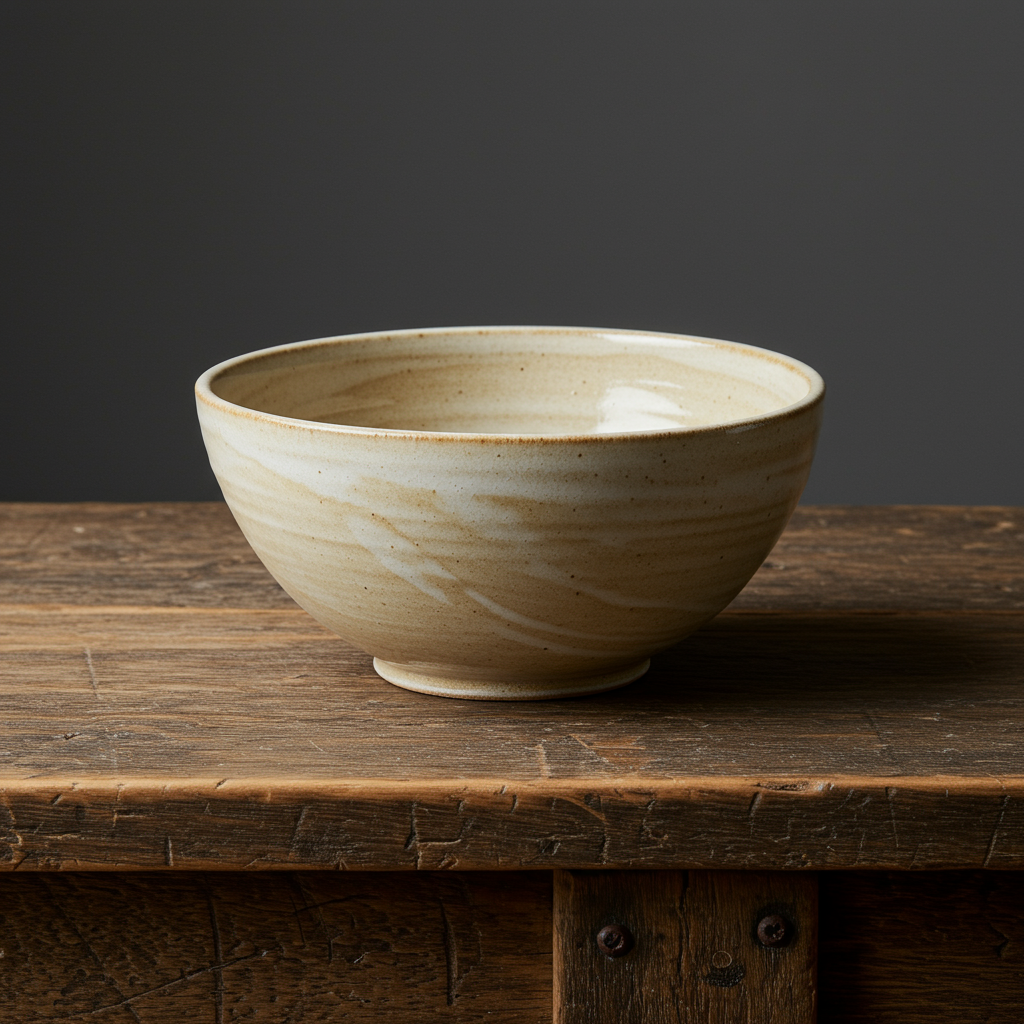

In [37]:
original_image = Image.from_file(
    location="empty-bowl-on-empty-table.png",
    mime_type="image/png"
)
original_image.show()

In [38]:
dest_filename = "empty-bowl-on-empty-table-copy.png"
original_image.save(dest_filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, dest_filename, dest_filename)

File empty-bowl-on-empty-table-copy.png uploaded to empty-bowl-on-empty-table-copy.png.


In [39]:
edit_model_name = "imagen-3.0-capability-001"

In [49]:
target_image_size = (1408, 768)

reframed_image, reframed_mask = image_editing_utils.pad_and_mask_image(
    original_image=original_image,
    target_size=target_image_size,
    vertical_offset_from_bottom=0.5,
    horizontal_offset_from_left=0.1,
)

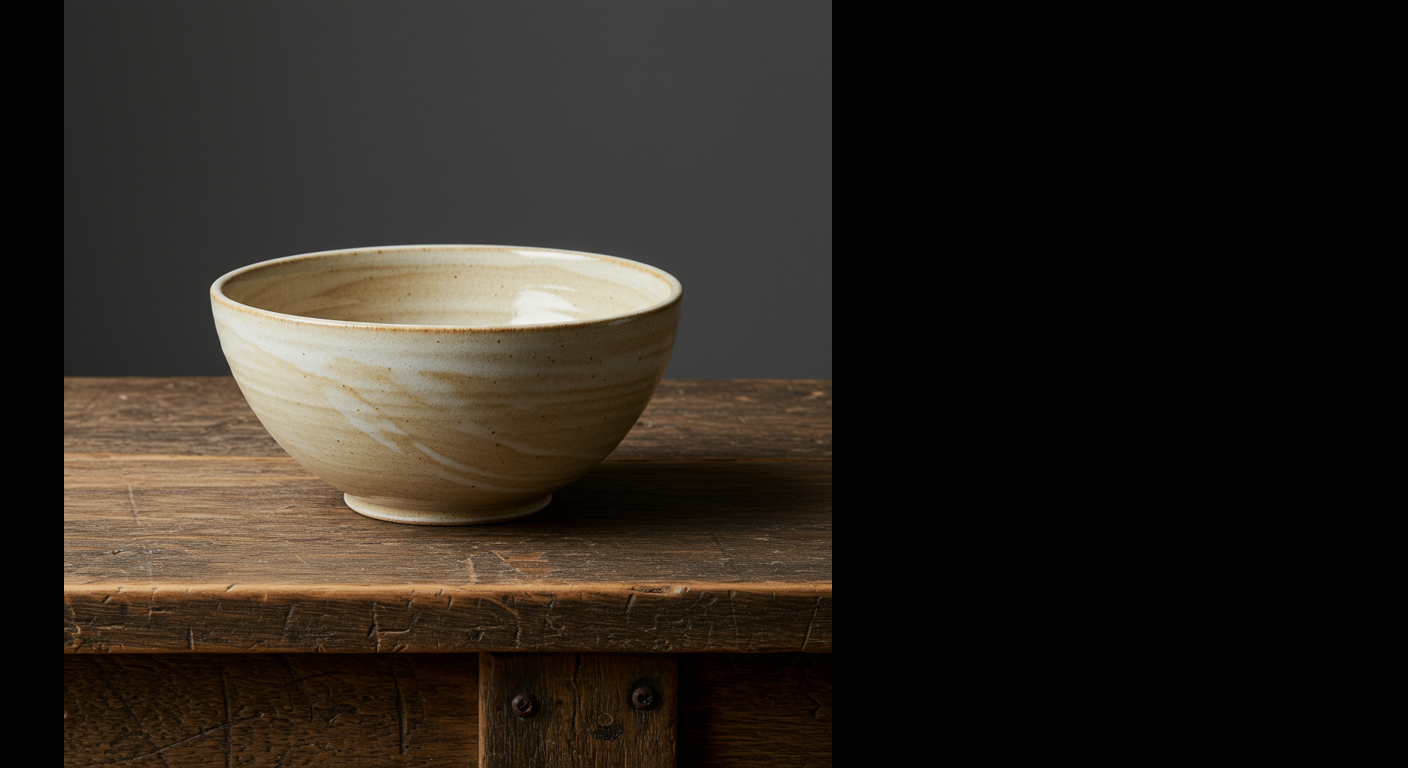

In [50]:
reframed_image.show()

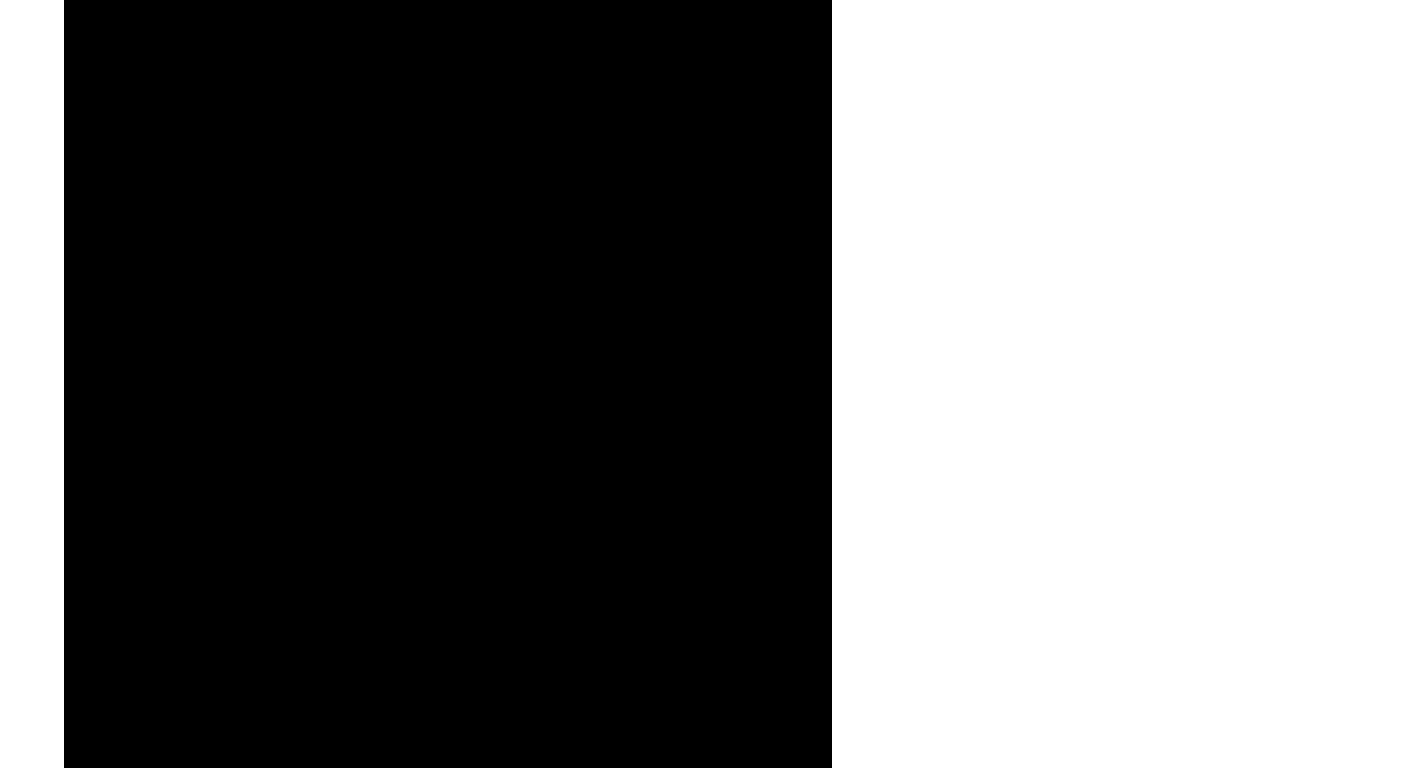

In [51]:
reframed_mask.show()

In [58]:
raw_ref_image = RawReferenceImage(
    # Fill in the appropriate configuration
    reference_image=reframed_image,reference_id=0
)

mask_ref_image = MaskReferenceImage(
    # Fill in the appropriate configuration
    reference_id=0,
    reference_image=mask_pil_outpaint_image,
    config=MaskReferenceConfig(
    mask_mode="MASK_MODE_USER_PROVIDED",
    mask_dilation=0.03,
    ),
)

In [59]:
outpainted_image = client.models.edit_image(
    model=edit_model_name,
    prompt="",
    reference_images=[raw_ref_image, mask_ref_image],
    config=EditImageConfig(
        edit_mode="EDIT_MODE_OUTPAINT",
        number_of_images=1,
        base_steps=35,
        safety_filter_level="BLOCK_ONLY_HIGH",
    ),
)

# Display result
outpainted_image.generated_images[0].image


Image(
  image_bytes=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x80\x00\x00\x03\x00\x08\x02\x00\x00\x00\x12ST\x9b\x00\x00\x00\x89zTXtRaw profile type iptc\x00\x00\x08\x99M\x8c1\x0e\x021\x0c\x04\xfb\xbc\xe2\x9e\x908\xeb\xb5]S\xd1Q\xf0\x81\xbb\\"!!\x81\xf8\x7fA...',
  mime_type='image/png'
)

In [60]:
filename = "empty-bowl-on-long-table.png"

outpainted_image.generated_images[0].image.save(filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, filename, filename)

File empty-bowl-on-long-table.png uploaded to empty-bowl-on-long-table.png.


In [61]:
raw_ref_image = RawReferenceImage(
    reference_image= outpainted_image,
    reference_id=0
)

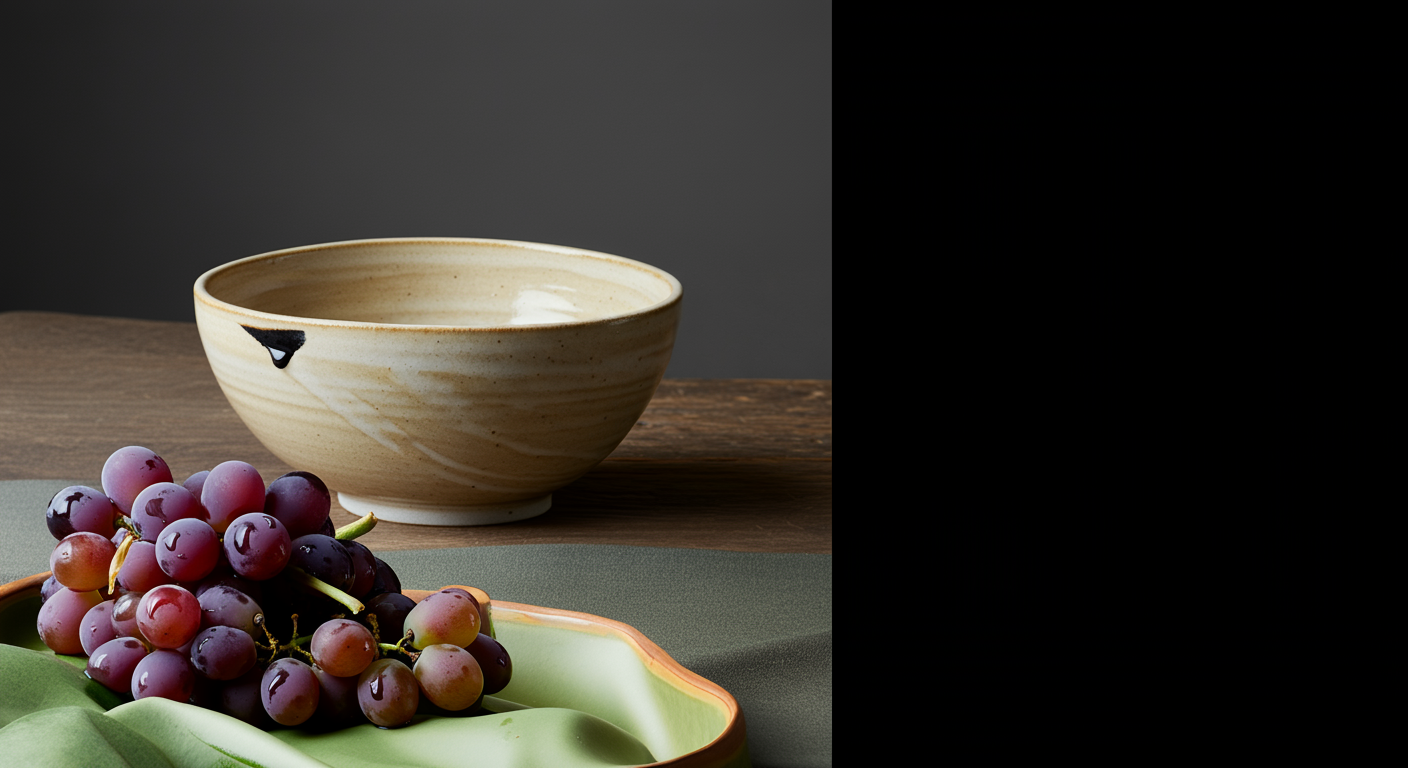

In [69]:
edit_prompt = "photoreal wet grapes added to the ceramic bowl[0]."
edited_image = client.models.edit_image(
    model=edit_model_name,
    prompt=edit_prompt,
    reference_images=[raw_ref_image,mask_ref_image],
    config=EditImageConfig(
        edit_mode= "EDIT_MODE_OUTPAINT" ,
        base_steps=35,
        number_of_images=1,
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
    ),
)

edited_image.generated_images[0].image.show()

In [70]:
filename = "grapes-in-bowl-on-long-table.png"

edited_image.generated_images[0].image.save(filename)
image_editing_utils.upload_file_to_gcs(
    gcs_bucket, filename, filename)

File grapes-in-bowl-on-long-table.png uploaded to grapes-in-bowl-on-long-table.png.


In [75]:
raw_ref_image = RawReferenceImage(
    reference_image= edited_image,
    reference_id=0
)

In [76]:
place_setting_mask = Image.from_file(location="place-setting-mask.png")
mask_ref_image = MaskReferenceImage(
    # Fill in the appropriate configuration
    reference_id=1,
    reference_image=place_setting_mask,
    config=MaskReferenceConfig(
        mask_mode="MASK_MODE_USER_PROVIDED",
        mask_dilation=0.1,
    ),
)

In [77]:
edit_prompt = "a fork on a napkin and a plate on the rustic table[1]"
inpainted_image = client.models.edit_image(
    model=edit_model_name,
    prompt=edit_prompt,
    reference_images=[raw_ref_image, mask_ref_image],
    config=EditImageConfig(
        edit_mode= "EDIT_MODE_INPAINT_INSERTION" ,
        number_of_images=1,
        safety_filter_level="BLOCK_MEDIUM_AND_ABOVE",
    ),
)

inpainted_image.generated_images[0].image.show()

ClientError: 400 INVALID_ARGUMENT. {'error': {'code': 400, 'message': 'Image should have either uri or image bytes.', 'status': 'INVALID_ARGUMENT'}}